# 1. Ingesta de Librerías

In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
df = pd.read_csv('df_final.csv')

In [3]:
df.head(3)

,truck,loader,ton,n_shovel,truck_total_cycle,loader_total_cycle,distance_empty,distance_full,date,ton_paladas,relacion_carga_transporte
0,CAEX56,PH06,299.682208,3,2158.0,315.0,4975.0,5191.0,2023-01-01,99.894069,6.850794
1,CAEX64,PH48,316.673117,3,1737.0,353.0,5152.0,4960.0,2023-01-01,105.557706,4.920680
2,CAEX41,PH06,340.529701,3,2210.0,388.0,5042.0,4859.0,2023-01-01,113.509900,5.695876


# 2. Preparación del datos

In [4]:
# Preparar los datos
X = df[['n_shovel', 'loader_total_cycle', 'ton' , 'distance_empty', 'distance_full']]
y = df['truck_total_cycle']  # Tonelaje como variable objetivo

modelo = DecisionTreeRegressor()
modelo.fit(X, y)

DecisionTreeRegressor()

In [5]:
print("predicciones para las 5 primeras casas:")
print(X.head())
print("las toneladas reales son:")
print(y.head())
print("las predicciones son:")
print(modelo.predict(X.head()))

predicciones para las 5 primeras casas:
   n_shovel  loader_total_cycle         ton  distance_empty  distance_full
0         3               315.0  299.682208          4975.0         5191.0
1         3               353.0  316.673117          5152.0         4960.0
2         3               388.0  340.529701          5042.0         4859.0
3         3               260.0  292.835476          5005.0         4869.0
4         3               148.0  337.056639          5614.0         5289.0
las toneladas reales son:
0    2158.0
1    1737.0
2    2210.0
3    2073.0
4    2346.0
Name: truck_total_cycle, dtype: float64
las predicciones son:
[2158. 1737. 2210. 2073. 2346.]


aquí se ve un modelo breve e idealista pero es necesario analizar los errores

# 2.1. MAE (Mean Absolute Error)

In [6]:
predicted_model = modelo.predict(X)
mean_absolute_error(y, predicted_model)

0.0

Se observa el error medio absoluto y como se mencionó anteriormente es demasiado idealista

# 2.2 Validación

In [7]:
train_X, val_X, train_y, val_y = train_test_split(X,y)

modelo = DecisionTreeRegressor()

modelo.fit(train_X, train_y)

val_predictions = modelo.predict(val_X)

print(mean_absolute_error(val_y, val_predictions))

486.95303720926296


En este caso se realiza un proceso de entreamiento y validación de un modelo de regresión lineal usando arbol de decisión donde podemos observar que se tiene una media absoluta de error de 487.6889 segundos en este caso, lo cual es esperable si se están utilizando principalmente el conjunto de validación que no utilizo en el entrenamiento

In [8]:
predicted_model = modelo.predict(X)
mean_absolute_error(y, predicted_model)

121.7392074860615

En este codigo utiliza datos reales como lo son la variable y, por ende es más engañosos porque ya "conoce" los datos

In [9]:
#Función para saber cual cantidad de hojas nos entrega el menor error absoluto para el modelo predictivo
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    modelo = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes)
    modelo.fit(train_X, train_y)
    preds_val=modelo.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

In [10]:
y_pred = modelo.predict(val_X) #se define la predicción de valores

In [11]:
for max_leaf_nodes in [5, 50, 500, 5000]:
    my_mae = get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y)
    print("Max leaf nodes: %d \t\t Mean Absolute Error: %d" %(max_leaf_nodes, my_mae))

Max leaf nodes: 5 		 Mean Absolute Error: 367
Max leaf nodes: 50 		 Mean Absolute Error: 337
Max leaf nodes: 500 		 Mean Absolute Error: 332
Max leaf nodes: 5000 		 Mean Absolute Error: 348


## 2.3 Evaluación modelo

In [12]:
# Evaluación del modelo
mae = mean_absolute_error(val_y, y_pred)
r2 = r2_score(val_y, y_pred)


print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")

Mean Absolute Error (MAE): 486.95303720926296
R-squared: 0.3117087477100243


En este caso vemos que el error sigue siendo el que teniamos en un principio (Aprox. 488) pero a su vez tenemos la medida de R2 con un 0.31 o 31% loo cual es muy bajo como para ser aceptado el modelo

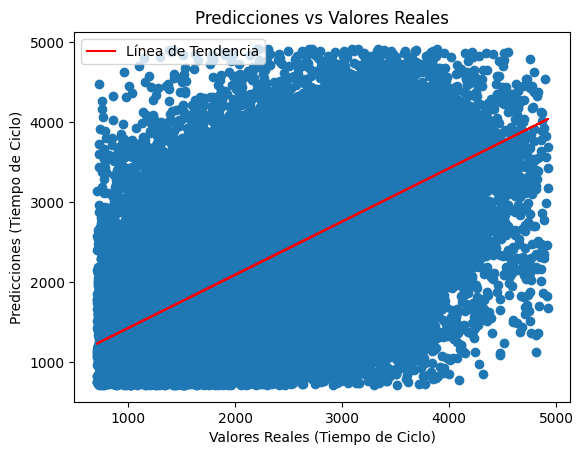

In [13]:
plt.scatter(val_y, val_predictions )
plt.xlabel('Valores Reales (Tiempo de Ciclo)')
plt.ylabel('Predicciones (Tiempo de Ciclo)')
plt.title('Predicciones vs Valores Reales')
# Calculamos los coeficientes de la línea de regresión
# np.polyfit devuelve la pendiente y la intersección de la línea
coef = np.polyfit(val_y, val_predictions, 1)
poly1d_fn = np.poly1d(coef)  # Crear función de la línea de regresión

# Dibujar la línea de tendencia
plt.plot(val_y, poly1d_fn(val_y), color='red', label='Línea de Tendencia')

# Mostrar leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

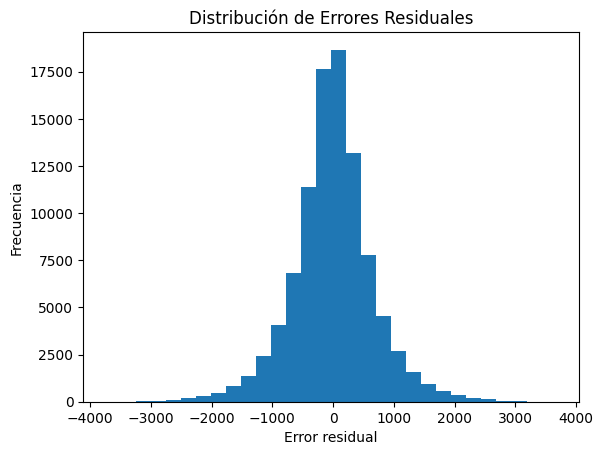

In [14]:
#Observamos los errores residuales generados con el fin de ver la diferencia entre los valores reales y los predichos. de tal manera de identificar areas a mejorar
residuals = val_y - y_pred
plt.hist(residuals, bins=30)
plt.xlabel('Error residual')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores Residuales')
plt.show()

## 2.4. Ajuste del Modelo

In [15]:
# Ajustar hiperparámetros del modelo
tree_model = DecisionTreeRegressor(max_depth=10, min_samples_split=10, min_samples_leaf=5, random_state=42 , max_leaf_nodes=500)
tree_model.fit(train_X, train_y)

# Evaluación después de ajustar los hiperparámetros
y_pred = tree_model.predict(val_X)
mae = mean_absolute_error(val_y, y_pred)
r2 = r2_score(val_y, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared: {r2}")

Mean Absolute Error (MAE): 332.07596339701735
R-squared: 0.6637465612921413


Al haber ajustado el modelo podemos ver que nuestro R2 ha aumentado significativamente a 0.6633 o 66.33% lo cual a mi parecer es mucho más aceptable y se procede a validación cruzada

In [16]:
# Validación cruzada con el modelo ajustado
scores = cross_val_score(tree_model, X, y, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)
print(f"RMSE promedio de validación cruzada: {rmse_scores.mean()} ± {rmse_scores.std()}")

RMSE promedio de validación cruzada: 491.6192880161037 ± 45.287121208326305


De la validación cruzada podemos ver el error medio que se tendra y también consideración su posible variabilidad

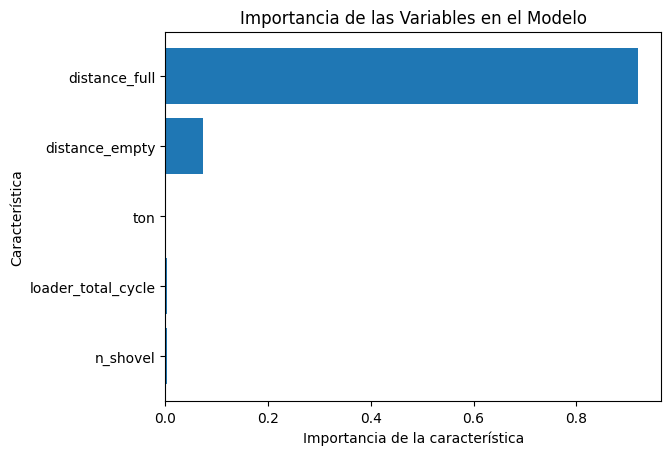

In [17]:
# Obtener la importancia de las características
importancias = tree_model.feature_importances_
caracteristicas = X.columns

# Graficar importancias
plt.barh(caracteristicas, importancias)
plt.xlabel('Importancia de la característica')
plt.ylabel('Característica')
plt.title('Importancia de las Variables en el Modelo')
plt.show()

Aquí podemos ver los factores más importes para predecir los datos del modelo, donde se aprecia que el más importante corresponde a la distancia que recorre lleno seguido de la distancia vacío

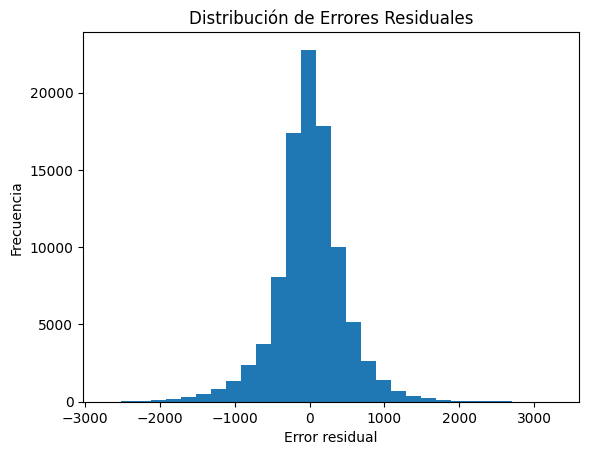

In [18]:
residuals = val_y - y_pred
plt.hist(residuals, bins=30)
plt.xlabel('Error residual')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores Residuales')
plt.show()

Se vuelven a evaluar los errore residuales luego de haber ajustado el modelo y podemos ver que se han disminuido ambas colas

## 2.5 Graficos de tendencias predictivas

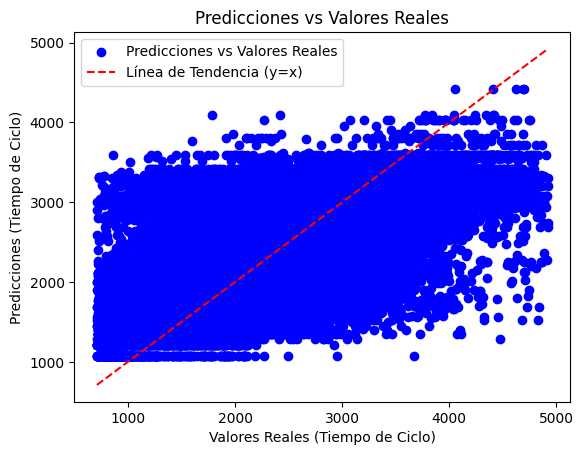

In [19]:
# Realizamos un grafico de dispersión con fin de ver que tanto se ajustan las predicciones a los valores realies
plt.scatter(val_y, y_pred, color='blue', label='Predicciones vs Valores Reales')

# Añadir una línea de tendencia (y = x, que indica el ajuste perfecto)
x = np.linspace(min(val_y), max(val_y), 100)
plt.plot(x, x, color='red', linestyle='--', label='Línea de Tendencia (y=x)')

# Etiquetas y título
plt.xlabel('Valores Reales (Tiempo de Ciclo)')
plt.ylabel('Predicciones (Tiempo de Ciclo)')
plt.title('Predicciones vs Valores Reales')
plt.legend()

# Mostrar gráfico
plt.show()

En este caso, que comparado al gráfico de tendencia que se realizo en eun principio este se encuentra más ajustado a la linea de tendencia y no como una nube de datos dispersa por el todo el gráfico

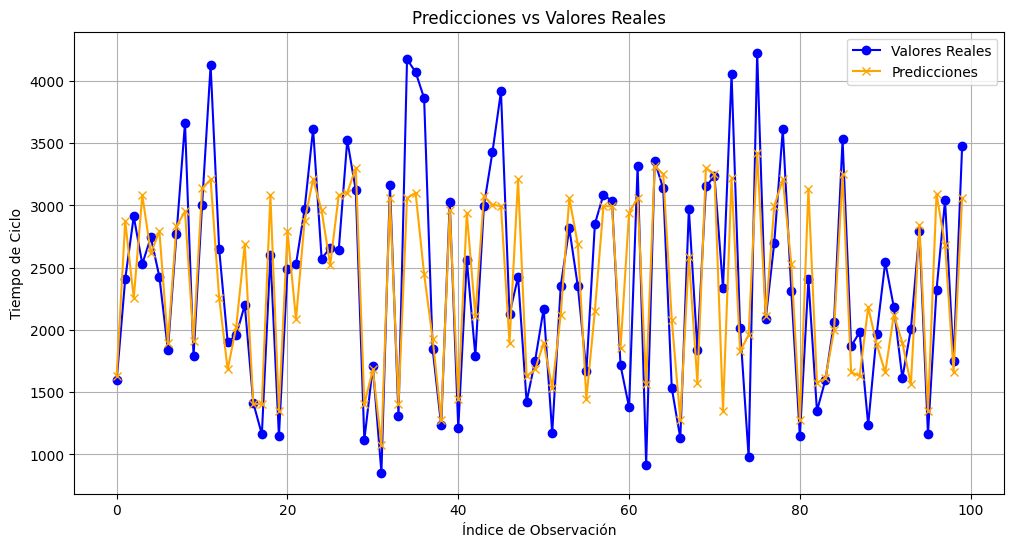

In [20]:
# Realizamos un gráfico de las tendencias comparando con los valores reales
y_pred = tree_model.predict(val_X)

# Convertir val_y y y_pred en DataFrames con una columna
val_y_df = pd.DataFrame(val_y).reset_index(drop=True)
y_pred_df = pd.DataFrame(y_pred).reset_index(drop=True)

# Creamos un DataFrame con los valores reales y las predicciones
results = pd.DataFrame({
    'Valores Reales': val_y_df.values.flatten(), 
    'Predicciones': y_pred_df.values.flatten() 
})

observaciones = 100
subset = results.iloc[:observaciones]
# Graficar
plt.figure(figsize=(12, 6))
plt.plot(subset.index, subset['Valores Reales'], label='Valores Reales', color='blue', marker='o')
plt.plot(subset.index, subset['Predicciones'], label='Predicciones', color='orange', marker='x')
plt.xlabel('Índice de Observación')
plt.ylabel('Tiempo de Ciclo')
plt.title('Predicciones vs Valores Reales')
plt.legend()
plt.grid()
plt.show()

In [21]:
df['truck_total_cycle'].describe()

count    385173.000000
mean       2271.744766
std         804.443340
min         711.000000
25%        1633.000000
50%        2123.000000
75%        2925.000000
max        4922.000000
Name: truck_total_cycle, dtype: float64

In [22]:
# Realizamos un grafico de predicción para los proximos 3 meses de la ultima fecha que presentaba la abse d edatos
# Generar fechas futuras
meses_futuro = 3
fecha_futuro = pd.date_range(start=df['date'].max(), periods=meses_futuro * 30, freq='D')

# Generamos caracteristicas futuras
caracteristicas_futuras = []
for date in fecha_futuro:
    # Se crean las caracteristicas de estudio con el fin de predecir al futuro con valores que estén entre el Quartil 1 y el Quartil 3 de los valores
    caracteristicas_futuras.append({
        'n_shovel': np.random.randint(df['n_shovel'].quantile(0.25), df['n_shovel'].quantile(0.75)),  
        'loader_total_cycle': np.random.randint(df['loader_total_cycle'].quantile(0.25), df['loader_total_cycle'].quantile(0.75)),  
        'ton': np.random.randint(df['ton'].quantile(0.25), df['ton'].quantile(0.75)),  
        'distance_empty': np.random.randint(df['distance_empty'].quantile(0.25), df['distance_empty'].quantile(0.75)), 
        'distance_full': np.random.randint(df['distance_full'].quantile(0.25), df['distance_full'].quantile(0.75)) 
    })

# Convertir a DataFrame
df_futuro = pd.DataFrame(caracteristicas_futuras)

# Predicciones futuras utilizando el modelo ajustado
prediccion_futuro = tree_model.predict(df_futuro)

# Crear un DataFrame con las fechas y las predicciones
future_results = pd.DataFrame({
    'date': fecha_futuro,
    'Predicciones': prediccion_futuro
})

# Agrupar los resultados históricos por fecha y calcular el promedio
historical_results = df.groupby('date').agg({'truck_total_cycle': 'mean'}).reset_index()
historical_results.rename(columns={'truck_total_cycle': 'Valores Reales'}, inplace=True)

# Combinar los resultados históricos y las predicciones futuras
combined_results = pd.concat([
    historical_results,
    future_results
], ignore_index=True)

# Asegurarse de que la columna 'date' sea de tipo datetime
combined_results['date'] = pd.to_datetime(combined_results['date'])

In [23]:
historical_results.head()

,date,Valores Reales
0,2023-01-01,2135.100977
1,2023-01-02,1998.058436
2,2023-01-03,2198.462029
3,2023-01-04,2545.512322
4,2023-01-05,2596.155707


In [24]:
future_results.head()

,date,Predicciones
0,2024-05-24,2869.232896
1,2024-05-25,1660.399239
2,2024-05-26,2589.413793
3,2024-05-27,2330.101448
4,2024-05-28,2195.907255


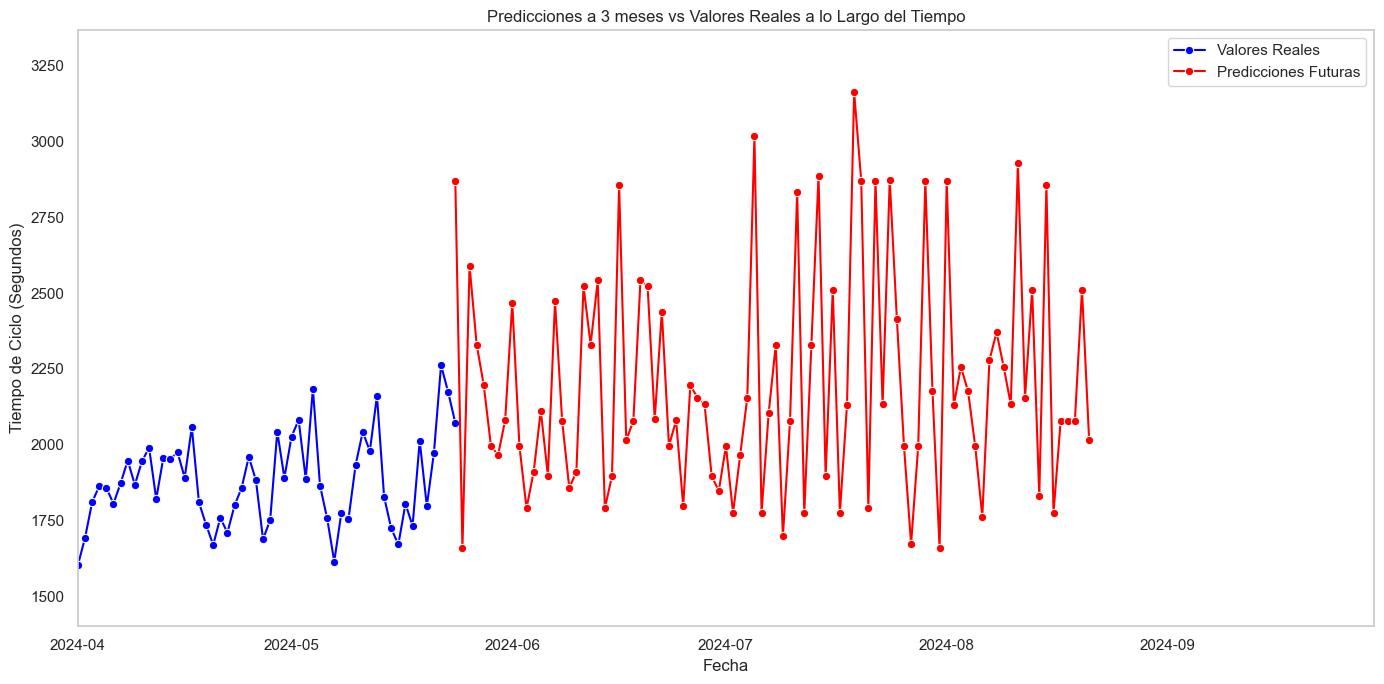

In [25]:
# Combinar los resultados históricos (opcional)
results = pd.DataFrame({
    'date': df['date'],  # Suponiendo que tienes una columna 'date' en tu df original
    'Valores Reales': df['truck_total_cycle'] # Suponiendo que este es el ciclo de camión
})

# Graficar con Seaborn
plt.figure(figsize=(14, 7))
sns.set_theme(style="whitegrid")

# Graficar los valores reales
sns.lineplot(x='date', y='Valores Reales', data=combined_results, label='Valores Reales', color='blue', marker='o')

# Graficar las predicciones futuras
sns.lineplot(x='date', y='Predicciones', data=combined_results, label='Predicciones Futuras', color='red', marker='o')

# Configurar el gráfico
plt.xlabel('Fecha')
plt.ylabel('Tiempo de Ciclo (Segundos)')
plt.title('Predicciones a 3 meses vs Valores Reales a lo Largo del Tiempo')

# Establecer límites del eje x para acotar las fechas
plt.xlim(pd.Timestamp('2024-04-01'), pd.Timestamp('2024-09-30'))
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

De esto podemos ver que si bien, presenta diferencias y pincos altos, de cierda manera el modelo predictivo se ajusta a los tiempos que se tendrían sin realizar las recomendaciones sugeridas para disminuir los tiempos de ciclo que enciertos casos son muy altos